<div hidden>
$\DeclareMathOperator{\tr}{tr}$
$\DeclareMathOperator{\sign}{sign}$
$\DeclareMathOperator{\argmin}{argmin}$
</div>

# Decomposição aditiva de matrizes

Considere novamente problemas de estimação cujo parâmetro tem a estrutura de matriz. Modelamos anteriormente o caso em que o parâmetro tem posto pequeno. Existem aplicações em que vale a pena modelar o parâmetro da forma

$$
B^* = \Gamma^* + S^*,  
$$

onde $\Gamma^*$ é uma matriz de posto $r$ e $S^*$ é uma matriz com no máximo $s$ entradas não-nulas. são matrizes $\mathbb{R}^{d_1\times d_2}$. Neste projeto iremos implementar métodos iterativos para achar a solução do seguinte estimador de mínimos quadrados regularizado:

\begin{equation*}
\begin{aligned}
& \underset{[\Gamma,S]\in(\mathbb{R}^{d_1\times d_2})^2}{\text{minimize}}
& & f(\Gamma,S) + \lambda\Vert \Gamma\Vert_N + \tau\Vert S\Vert_1, \\
& \text{sujeito à}
& & \Vert\Gamma\Vert_\infty\le a, 
\end{aligned}
\end{equation*}
onde 

$$
f(\Gamma, S) := \frac{1}{2n}\sum_{i=1}^n\left\{
y_i-\tr\left(
X_i^\top(\Gamma + S)
\right)
\right\}^2, 
$$

$(y_1,X_1), \ldots, (y_n,X_n)$ é uma amostra de labels/features em $\mathbb{R}\times\mathbb{R}^{d_1\times d_2}$. Àcima, $\lambda,\tau,a>0$ são hyper-parâmetros,  

$$
\Vert \Gamma\Vert_N := \sum_{j=1}^{\min\{d_1,d_2\}}\sigma(B),
$$

é a *norma nuclear* da matriz $\Gamma$, onde $\sigma_1(\Gamma)\ge\cdots\ge\sigma_{\min\{d_1,d_2\}}(\Gamma)$ são os valores singulares de $B$. Além disso,  

$$
\Vert \Gamma\Vert_\infty := \max_{(j,k)\in[d_1]\times[d_2]}|\Gamma_{jk}|,
$$

é a *norma $\ell_\infty$* da matriz $\Gamma$ e 

$$
\Vert S\Vert_1 := \sum_{j=1}^{d_1}\sum_{k=1}^{d_2}|S_{jk}|,
$$

é a *norma $\ell_1$* da matriz $S$.


Exemplos de aplicação de variações deste problema incluem [*multi-task learning*](https://medium.com/gumgum-tech/multi-task-learning-what-is-it-how-does-it-work-and-why-does-it-work-294769c457bb) e [*análise multiômica*](https://academic.oup.com/bioinformatics/article/37/16/2259/6154849?login=false).
  

# Soft-Thresholding matricial


Os métodos que veremos para os problemas anteriores se baseam na idéia de *splitting*. Por exemplo, note que o o problema de otimização em PCA robusta exige otimizar em duas variáveis $[\Gamma, S]$. Entretanto otimizar simultaneamente é mais difícil do que otimizar alternadamente. 

Precisaremos computar os operadores proximais das normas nuclear e $\ell_1$. O *operador proximal* da norma $\lambda\Vert\cdot\Vert_N$ com restrição $\Vert\Gamma\Vert_{\infty}\le a$ é 

\begin{equation*}
P_N(W,\lambda,a) = 
\begin{aligned}
& \underset{\Gamma \in \mathbb{R}^{d_1\times d_2}}{\text{armin}}
& & \frac{1}{2}\Vert W - \Gamma \Vert_F^2 + 
\lambda\Vert \Gamma\Vert_N, \\
& \text{sujeito à}
& & \Vert\Gamma\Vert_\infty\le a.
\end{aligned}
\end{equation*}

$P_N(W,\lambda,a)$ tem fórmula explicíta. Dados $\gamma\in\mathbb{R}$, defina

$$
S_a(\gamma,\lambda):=\sign(\gamma)\cdot\min\left\{
\max\{\gamma-\lambda,0\}, a
\right\}.
$$

Àcima, $\sign(\gamma)$ é o sinal de $\gamma$. Seja agora a decomposição de valores singulares (SVD) de $W$:
$$
W = U\cdot D(\gamma_1,\ldots,\gamma_r)\cdot V^\top.
$$
Então, 
$$
P_N(W,\lambda,a) = U\cdot D\left( S_a(\gamma_1,\lambda),\ldots, S_a(\gamma_r,\lambda)\right)\cdot V^\top, 
$$
chamado de matriz *constraint soft-thresholding* de $W$.

O *operador proximal* da norma $\tau\Vert\cdot\Vert_1$ é 

$$
P_1(W,\tau)\in\argmin_{S\in\mathbb{R}^{d_1\times d_2}}\left\{
\frac{1}{2}\Vert W - S\Vert_F^2 + \tau\Vert S\Vert_1
\right\}.
$$

$P_1(W,\tau)$ também tem fórmula explicíta. Dados $\gamma\in\mathbb{R}$, defina

$$
S(\gamma,\lambda):=\sign(\gamma)\cdot\max\{\gamma-\lambda,0\}.
$$

$P_1(W,\tau)$ é a matriz $d_1\times d_2$ cuja $[j,k]$-ézima entrada é $S(W_{j,k},\tau)$. 

In [1]:
import matplotlib
import numpy as np
import scipy
from scipy.stats import ortho_group
import seaborn as sns
import matplotlib.pyplot as plt
import numpy.linalg as la
import math

# Exercício 1:

Construa as funções ``soft(x,l)`` que retorna $S(x,\lambda)$ e ``csoft(x,l,a)`` que retorna $S_a(x,\lambda)$. 

In [2]:
#Escreva o código aqui
def soft(x, l):
    return np.sign(x) * np.maximum(x - l, 0)

def csoft(x, l, a):
    return np.sign(x) * np.minimum(np.maximum(x - l, 0), a)

# Exercício 2: Gerando dados

Construa uma função ``data_genG(n,d1,d2,r,Gamma_mag)`` que toma $d_1$, $d_2$, posto $r$ e número positivo ``Gamma_mag`` e retorna a matriz $\Gamma^*$ de dimensão $d_1\times d_2$ e posto $r$ com $\Vert\Gamma\Vert_\infty$ no máximo $\Gamma_{mag}/\sqrt{n}$. Ao gerar esta matriz $\Gamma^*$, use a função ```scipy.stats.ortho_group``` para construir duas matrizes $U$ e $V$ aleatórias ortogonais de dimensões $d_1\times r$ e $d_2\times r$ respectivamente; compute $U\cdot D(\Gamma_{mag},\ldots,\Gamma_{mag})\cdot V^\top$ e finalmente, normalize esta matriz entrada por entrada para satisfazer $\Vert\Gamma^*\Vert\le\Gamma_{mag}/\sqrt{n}$.

In [3]:
#Escreva o código aqui
def data_genG(n, d1, d2, r, Gamma_mag):
    # Montando as matrizes U, D e V
    D = np.diag(np.full(r, Gamma_mag))
    U = ortho_group.rvs(dim = d1)[:, :r]
    V = ortho_group.rvs(dim = d2)[:, :r]
    
    # Calculando a matriz Gamma*
    G = U @ D @ V.T

    # Normalizando suas entradas
    G = (G/np.max(np.abs(G))) * (Gamma_mag/np.sqrt(n))

    return G

In [4]:
#Exemplo:
n=100
d_1=10
d_2=10
r=5
Gamma_mag=10
Gamma_true = data_genG(n,d_1,d_2,r,Gamma_mag)
Gamma_true.shape, np.max(abs(Gamma_true)), Gamma_true, 

((10, 10),
 1.0,
 array([[-8.81062139e-01, -1.29341392e-01,  6.49197679e-01,
         -3.91079308e-01,  5.99781377e-01,  5.81251990e-01,
         -8.22848924e-01,  1.32713718e-01,  6.01628546e-01,
         -8.00649684e-01],
        [ 3.54906865e-01, -7.09069091e-01, -6.54284028e-02,
         -8.18417265e-01,  6.82321004e-01, -2.10718543e-01,
          9.98454968e-01,  7.82466995e-01, -1.49150914e-02,
          1.73240089e-01],
        [-8.08105464e-02,  9.73107210e-01, -3.42856237e-01,
         -5.50498948e-02, -4.45004465e-02,  1.25992934e-01,
         -2.69361677e-02, -5.02162650e-01, -7.23351813e-01,
          6.37697000e-01],
        [ 3.95990393e-01,  4.54510380e-01,  6.47110323e-01,
          5.66192459e-01,  2.00802442e-01, -5.90020663e-01,
          3.58369927e-01,  7.24910230e-01, -5.07064944e-01,
         -2.42804493e-01],
        [-9.60938119e-02,  7.70596253e-01,  6.55136037e-01,
          4.59068375e-01,  1.98257042e-01, -1.35993274e-01,
         -2.52176633e-01,  2.529319

# Exercício 3: Gerando dados

Construa uma função ``data_genS(d1,d2,s,S_mag)`` que toma $d_1$, $d_2$, esparsidade $s\in[d_1d_2]$ e número positivo ``S_mag`` e retorna a matriz $d_1\times d_2$ com $s$ entradas iguais a $S_{mag}$ e outras entradas iguais a zero. Escolha as entradas não-nulas aleatoriamente.

In [5]:
#Escreva o código aqui
def data_genS(d1, d2, s, S_mag):
    # Sorteando as entradas não nulas
    not_null_entries = np.random.choice(range(d1*d2), s)
    # Inicializando a matriz S como um vetor nulo
    S = np.zeros(d1*d2)
    # Colocando as entradas não nulas no vetor
    S[not_null_entries] = S_mag
    # Redimensionando para a matriz desejada
    S = S.reshape((d1, d2))
    
    return S

In [6]:
#Exemplo:
d_1=12
d_2=5
s=10
S_mag=10
S_true = data_genS(d_1,d_2,s,S_mag)
S_true

array([[ 0., 10.,  0.,  0., 10.],
       [10.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., 10.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [10.,  0.,  0.,  0., 10.],
       [ 0.,  0.,  0.,  0., 10.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., 10.],
       [10., 10.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.]])

# Exercício 4:

Construa uma função ``data_genXe(n,d_1,d_2,Gamma_true,S_true,sd)`` que toma $n$, $d_1$, $d_2$, $\Gamma^*$, $S^*$ e um número positivo ``sd`` e constrói os dados ``X``, uma lista de $n$ matrizes $X_i$ de dimensão $d_1\times d_2$ independentes cujas entradas são iid normais padrão. A função também retorna o vetor ``y`` de dimensão $n$ cujas coordenadas satisfazem

$$
y_i = \tr(X_i^\top (\Gamma^* + S^*)) + \text{sd}\cdot\epsilon_i,
$$
onde $\{\epsilon_i\}_{i=1}^n$ é uma sequência iid de normais padrão. 

In [7]:
#Escreva o código aqui
def data_genXe(n, d_1, d_2, Gamma_true, S_true, sd):
    X = []
    y = np.zeros((n, 1))

    for i in range(n):
        Xi = np.random.standard_normal((d_1, d_2))
        X.append(Xi)
        ei = np.random.standard_normal(1)[0]
        y[i] = np.trace(Xi.T @ (Gamma_true + S_true)) + sd * ei

    return X, y

In [8]:
#Exemplo:
d_1=40
d_2=40
r=5
s=10
Gamma_mag=10
S_mag=10
sd = 1
n = 100

Gamma_true = data_genG(n,d_1,d_2,r,Gamma_mag)
S_true = data_genS(d_1,d_2,s,S_mag)
B_true = Gamma_true + S_true
X,y = data_genXe(n,d_1,d_2,Gamma_true,S_true,sd)

In [9]:
type(X), len(X), X[0].shape

(list, 100, (40, 40))

In [10]:
type(y), len(y), y.shape

(numpy.ndarray, 100, (100, 1))

# Exercício 5:

Construa uma função `df(Gamma,S)` que retorna o gradiente $\nabla f(\Gamma, S)$.

In [11]:
#Escreva o código aqui
def df(Gamma, S):
    grad = 0

    for i in range(n):
        grad -= (1/n) * (y[i] - np.trace(X[i].T @ (Gamma + S))) * X[i]

    return grad

In [12]:
df(Gamma_true,S_true).shape, df(Gamma_true,S_true)

((40, 40),
 array([[ 1.52967111e-01,  1.26692670e-01, -6.70814170e-02, ...,
          7.73464071e-02,  6.62969672e-02, -5.93836928e-02],
        [-5.21994767e-03,  2.14671019e-01, -7.15910017e-02, ...,
         -1.86658336e-01,  9.79775204e-02,  2.55369196e-03],
        [-9.81171917e-02, -4.35801990e-02, -3.44770229e-02, ...,
          1.34812267e-01,  8.36207971e-02, -1.20855015e-02],
        ...,
        [-2.05415323e-02, -4.29130063e-03, -2.13901285e-04, ...,
          5.51155757e-02,  8.97296805e-02,  1.06952704e-01],
        [-1.86945976e-01,  2.04429302e-02,  1.71218023e-01, ...,
          6.87394849e-02, -9.04530183e-02,  2.92610542e-02],
        [-1.59701814e-02, -1.11703701e-01,  1.51367321e-01, ...,
         -1.74089999e-02,  9.61726976e-02,  7.00761946e-02]]))

# Exercício 6: 

Vamos usar o método gradiente proximal com splitting para resolver o problema àcima:

\begin{align*}
W_{\Gamma,k+1} &:= \Gamma_k - \frac{1}{L}\nabla f(\Gamma_k,S_k),\\
W_{S,k+1} &:= S_k - \frac{1}{L}\nabla f(\Gamma_k,S_k),\\
\Gamma_{k+1} &:= P_N\left(W_{\Gamma, k+1},\frac{\lambda}{L},a\right), \\
S_{k+1} &:= P_1\left(W_{S, k+1},\frac{\tau}{L}\right).
\end{align*}

Construa uma função ``trace_reg_MD(Df, n,d_1,d_2,X,y,L,lambd,tau,a, Gamma0,S0,t_final)`` onde `Df` é uma função que retorna o gradiente, $1/L$ é o passo, ``lambd`` ($=\lambda$) e ``tau`` ($=\tau$) são os fatores de penalização, ``Gamma0`` e ``S0`` são os pontos iniciais, e a variável ``t_final`` é o número de iterações. A função deve retornar a sequência $k\mapsto\Vert\nabla f(\Gamma_k,S_k)\Vert_F^2$ e os últimos iterados $\Gamma_{\text{t_final}}$ e $S_{\text{t_final}}$. Use hyper-parâmetros:

\begin{align*}
a &= \frac{\Gamma_{mag}}{\sqrt{n}},\\
\lambda &= \text{sd}\sqrt{\frac{d_1+d_2}{n}},\\
\tau &= \text{sd}\sqrt{\frac{\log(d_1d_2)}{n}} + \frac{\Gamma_{mag}}{\sqrt{n}}.
\end{align*}

e passo $A/L$ ajustando $A\ge1$ com
$$
L = A \cdot \lambda_{\max}\left(
\frac{1}{n}\sum_{i=1}^n\text{vec}(X_i)\text{vec}^\top(X_i)
\right),
$$ 
onde $\text{vec}(X_i)$ representa a matrix $d_1\times d_2$ $X_i$ em forma vetorial de dimensão $d_1d_2$.

In [13]:
#Escreva o código aqui
def trace_reg_MD(Df, n, d_1, d_2, X, y, L, lambd, tau, a, Gamma0, S0, t_final):
    # Inicializando o histórico das normas do gradiente
    grad_history = []
    # Inicializando Gamma e S nos seus respectivos pontos iniciais
    Gamma = Gamma0
    S = S0

    # Em cada iteração...
    for _ in range(t_final):
        # Calcula o gradiente
        grad = Df(Gamma, S)

        # Calcula sua norma e salva na lista
        grad_norm = np.sum(grad ** 2)
        grad_history.append(grad_norm)

        # Atualiza os Ws
        W_Gamma = Gamma - (1/L) * grad
        W_S = S - (1/L) * grad

        # Atualiza o Gamma
        U, D, Vt = la.svd(W_Gamma)
        Gamma = U @ np.diag(csoft(D, lambd/L, a)) @ Vt

        # Atualiza o S
        S = soft(W_S, tau/L)

    return grad_history, Gamma, S

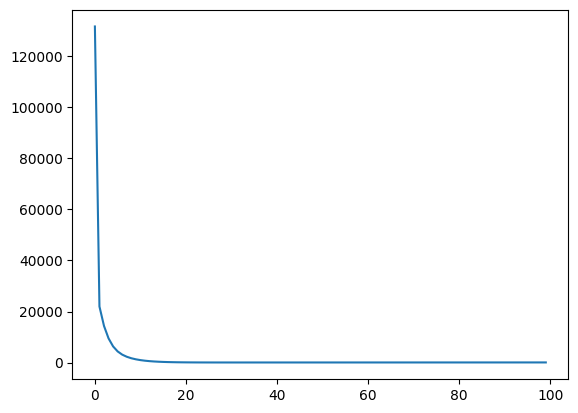

In [14]:
#Exemplo:
Gamma0 = np.ones((d_1,d_2))
S0 = np.ones((d_1,d_2))
t_final = 100

#Cálculo de L:
aux = []
for i in range(n):
    xi = np.asarray(X[i])
    aux.append(xi @ xi.T)
L = 4*np.max(la.eigvalsh(sum(aux)/n))


lambd = sd*np.sqrt((d_1+d_2)/n)
a = Gamma_mag/np.sqrt(n)
tau = sd*np.sqrt(np.log(d_1*d_2)/n) + Gamma_mag/np.sqrt(n)

f1 = trace_reg_MD(df, n,d_1,d_2,X,y,L,lambd,tau,a,Gamma0,S0,t_final)
plt.plot(f1[0])

# Exercício 7: 

O que acontece se $A$ for muito pequeno? 

**Resposta**: Se $A$ for muito pequeno, o passo do modelo será muito grande, fazendo com que ele não consiga realizar uma descida estável, ou seja, o gradiente pode não se aproximar continuamente de um ponto estacionário. Com isso, o modelo não é capaz de aprender adequadamente.

# Exercício 8: 

Agora, vamos usar o método gradiente proximal com splitting *acelerado*: iniciando de `[Gamma0,S0]=[Zg0,Zs0]` e $t_0=1$:

\begin{align*}
Z_{\Gamma, k+1}&:= P_N\left(
\Gamma_k - (1/L)\nabla f(\Gamma_k,S_k), \frac{\lambda}{L}, a
\right),\\
Z_{S, k+1}&:= P_1\left(
S_k - (1/L)\nabla f(\Gamma_k,S_k), \frac{\tau}{L}
\right),\\
t_{k+1} &:= \frac{1+\sqrt{1+4t_k^2}}{2},\\
\Gamma_{k+1} &:= Z_{\Gamma, k+1} + \frac{t_{k}-1}{t_{k+1}}(Z_{\Gamma, k+1} - Z_{\Gamma, k}),\\
S_{k+1} &:= Z_{S, k+1} + \frac{t_{k}-1}{t_{k+1}}(Z_{S, k+1} - Z_{S, k}).
\end{align*}

Construa uma função ``trace_reg_MD_acc(Df, n,d_1,d_2,X,y,L,lambd,tau,a,Gamma0,S0,t_final)`` onde `Df` é uma função que retorna o gradiente, $1/L$ é o passo, ``lambd`` ($=\lambda$) e ``tau`` ($=\tau$) são os fatores de penalização, ``Gamma0`` e ``S0`` são os pontos iniciais, e a variável ``t_final`` é o número de iterações. A função deve retornar a sequência $k\mapsto\Vert\nabla f(\Gamma_k,S_k)\Vert_F^2$ e os últimos iterados $\Gamma_{\text{t_final}}$ e $S_{\text{t_final}}$. Use hyper-parâmetros:

\begin{align*}
a &= \frac{\Gamma_{mag}}{\sqrt{n}},\\
\lambda &= \text{sd}\sqrt{\frac{d_1+d_2}{n}},\\
\tau &= \text{sd}\sqrt{\frac{\log(d_1d_2)}{n}} + \frac{\Gamma_{mag}}{\sqrt{n}}.
\end{align*}

e passo $A/L$ ajustando $A\ge1$ com
$$
L = A \cdot \lambda_{\max}\left(
\frac{1}{n}\sum_{i=1}^n\text{vec}(X_i)\text{vec}^\top(X_i)
\right).
$$  

In [15]:
#Escreva o código aqui
def trace_reg_MD_acc(Df, n, d_1, d_2, X, y, L, lambd, tau, a, Gamma0, S0, t_final):
    # Inicializando o histórico das normas do gradiente
    grad_history = []
    # Inicializando as variáveis
    Gamma = Gamma0
    S = S0
    Z_Gamma0 = Gamma0
    Z_Gamma1 = Z_Gamma0
    Z_S0 = S0
    Z_S1 = Z_S0
    t0 = 1
    t1 = t0

    # Em cada iteração...
    for _ in range(t_final):
        # Calcula o gradiente
        grad = Df(Gamma, S)

        # Calcula sua norma e salva na lista
        grad_norm = np.sum(grad ** 2)
        grad_history.append(grad_norm)
        
        # Avança e atualiza o Z_Gamma
        Z_Gamma0 = Z_Gamma1
        U, D, Vt = la.svd(Gamma - (1/L) * grad, full_matrices = False)
        Z_Gamma1 = U @ np.diag(csoft(D, lambd/L, a)) @ Vt

        # Avança e atualiza o Z_S
        Z_S0 = Z_S1
        # Z_S1 = soft(S - (1/L) * grad, tau/L)
        U, D, Vt = la.svd(S - (1/L) * grad, full_matrices = False)
        Z_S1 = U @ np.diag(soft(D, tau/L)) @ Vt

        # Avança e atualiza o t
        t0 = t1
        t1 = (1 + np.sqrt(1 + 4 * (t0 ** 2)))/2

        # Atualiza o Gamma
        Gamma = Z_Gamma1 + ((t0 - 1)/t1) * (Z_Gamma1 - Z_Gamma0)

        # Atualiza o S
        S = Z_S1 + ((t0 - 1)/t1) * (Z_S1 - Z_S0)

    return grad_history, Gamma, S

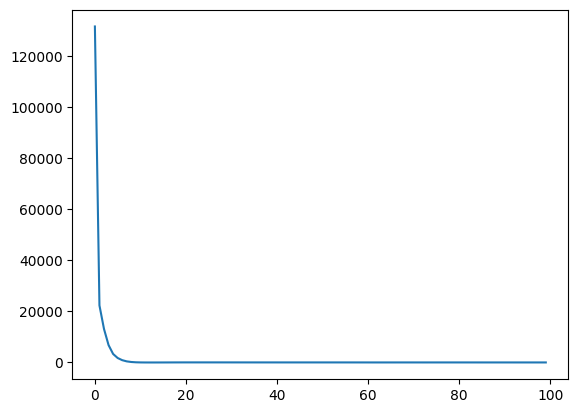

In [16]:
Gamma0 = np.ones((d_1,d_2))
S0 = np.ones((d_1,d_2))
t_final = 100

#Cálculo de L:
aux = []
for i in range(n):
    xi = np.asarray(X[i])
    aux.append(xi @ xi.T)
L = 4*np.max(la.eigvalsh(sum(aux)/n))

lambd = sd*np.sqrt((d_1+d_2)/n)
a = Gamma_mag/np.sqrt(n)
tau = sd*np.sqrt(np.log(d_1*d_2)/n) + Gamma_mag/np.sqrt(n)

f2 = trace_reg_MD_acc(df, n,d_1,d_2,X,y,L,lambd,tau,a,Gamma0,S0,t_final)
plt.plot(f2[0])

# Exercício 9: 

Implemente num mesmo gráfico os erros $k\mapsto\Vert\nabla f(\Gamma_k,S_k)\Vert_F^2$ de cada método em função no número de iterações.

[]

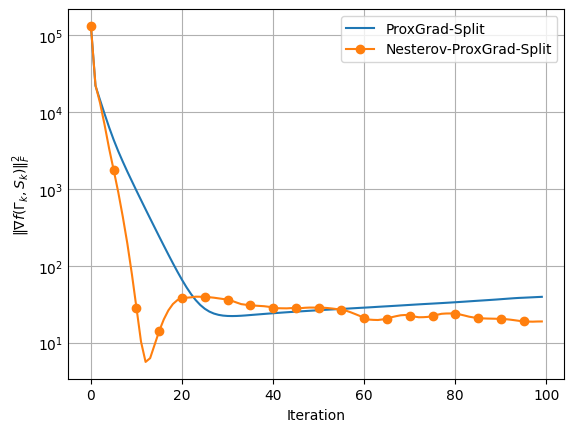

In [17]:
#Escreva o código aqui
plt.plot(f1[0], label = "ProxGrad-Split")
plt.plot(f2[0], label = "Nesterov-ProxGrad-Split", marker = "o", markevery = 5)
plt.xlabel("Iteration")
plt.ylabel(r"$\|\nabla f(\Gamma_k, S_k)\|_F^2$")
plt.yscale("log")
plt.grid(True)
plt.tick_params(axis = "y", which = "both", length = 0)
plt.legend()
plt.plot()

# PCA robusta

O modelo anterior é *supervisionado*. Em *visão computacional*, um modelo relacionando mas não-supervisionado consiste em estimar cada uma das componentes $[\Gamma^*,S^*]$ tendo apenas uma medição ruidosa da soma $B^*=\Gamma^*+S^*$, por exemplo, ao separar de uma foto um carro (image esparsa) do ambiente (imagem de posto pequeno):

![](Robust-PCA.png)

Neste caso, resolvemos:

\begin{equation*}
\begin{aligned}
& \underset{[\Gamma,S]\in(\mathbb{R}^{d_1\times d_2})^2}{\text{minimize}}
& & F(\Gamma,S) + \lambda\Vert \Gamma\Vert_N + \tau\Vert S\Vert_1, \\
& \text{sujeito à}
& & \Vert\Gamma\Vert_\infty\le a, 
\end{aligned}
\end{equation*}

onde 

$$
F(\Gamma,S) = \frac{1}{2}\Vert Y - (\Gamma+S)\Vert_F^2, 
$$

$Y$ é uma matriz de dados em $\mathbb{R}\times\mathbb{R}^{d_1\times d_2}$, por exemplo, uma imagem ruidosa. Aplicações incluem *vigilância por vídeos*, *reconhecimento facial*, *topic modelling* (incluindo *latent semantic analysis* e *sentiment analysis*) e *recomendação de sistemas* sujeito a dados corruptos. Veja e.g. [Robust PCA?](https://arxiv.org/abs/0912.3599) e [Video](https://www.youtube.com/watch?v=yDpz0PqULXQ).

# Exercício 10:

Construa uma função ``data_genYe(n,d_1,d_2,B_true,sd)`` que toma $n$, $d_1$, $d_2$, $B^*$, e um número positivo ``sd`` e constrói a matriz de dados ``Y`` tal que

$$
Y = B^* + \text{sd}\cdot\Xi,
$$

onde $\Xi$ é uma matriz $d_1\times d_2$ cujas entradas são iid $N(0,1)$. NOTA: Iremos usar as mesmas funções anteriores para gerar $\Gamma^*$ e $S^*$.

In [18]:
#Escreva o código aqui
def data_genYe(n, d_1, d_2, B_true, sd):
    # Gerando Xi
    Xi = np.random.standard_normal((d_1, d_2))
    # Calculando Y
    Y = B_true + sd * Xi

    return Y

In [19]:
#Exemplo:
d_1=40
d_2=40
r=5
s=10
Gamma_mag=10
S_mag=10
sd = .1
n = 100

Gamma_true = data_genG(n,d_1,d_2,r,Gamma_mag)
S_true = data_genS(d_1,d_2,s,S_mag)
B_true = Gamma_true + S_true
Y = data_genYe(n,d_1,d_2,B_true,sd)

In [20]:
Y.shape, Y

((40, 40),
 array([[-0.2824635 ,  0.34560621, -0.06572559, ...,  0.11425207,
         -0.15318634,  0.04817891],
        [ 0.13962899, -0.31977711,  0.12741098, ...,  0.00108836,
          0.33869267, -0.02158317],
        [ 0.279342  ,  0.06094522,  0.04564324, ...,  0.23120823,
          0.17203969,  0.37803743],
        ...,
        [ 0.34095623, -0.20886578, -0.01194671, ...,  0.20125048,
         -0.14768053, -0.30946359],
        [-0.26712753,  0.24190972,  0.16968861, ..., -0.07077281,
         -0.01375928, -0.39216043],
        [-0.16773575, -0.05368646, -0.03375511, ..., -0.22234429,
         -0.15488772, -0.21653384]]))

# Exercício 11:

Construa uma função `dF(Gamma,S)` que retorna o gradiente $\nabla F(\Gamma,S)$.

In [21]:
#Escreva o código aqui
def dF(Gamma, S):
    return -(Y - (Gamma + S))

# Exercício 12: 

Vamos usar o método gradiente proximal com splitting para resolver o problema àcima. Ele tem exatamente a mesma expressão do Exercício 6 mas usando $\nabla F(\Gamma,S)$. Implemente o algoritmo com

\begin{align*}
a &= \frac{\Gamma_{mag}}{\sqrt{n}},\\
\lambda &= \text{sd}\sqrt{\frac{d_1+d_2}{n}},\\
\tau &= \text{sd}\sqrt{\frac{\log(d_1d_2)}{n}} + \frac{\Gamma_{mag}}{\sqrt{n}}.
\end{align*}

e passo $1/L$. PERGUNTA: Exiba um limite aproximado em que para $L$ os métodos convergem e para um $L$ próximo os métodos não convergem. 

Em seguida, implemente o método gradiente proximal com splitting acelerado: é o mesmo que o exercício 8 mas usando $\nabla F(\Gamma,S)$.

Finalmente, plote num mesmo gráfico a sequência de erros $\Vert\nabla f(\Gamma_k,S_k)\Vert_F^2$ para os dois métodos.

In [22]:
# Setando os hiperparâmetros
a = Gamma_mag/np.sqrt(n)
lambd = sd * np.sqrt((d_1 + d_2)/n)
tau = sd * np.sqrt(np.log(d_1 * d_2)/n) + Gamma_mag/np.sqrt(n)

Best L:  0.8


[]

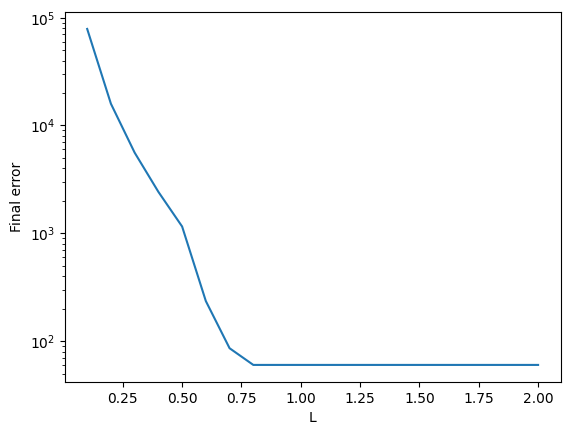

In [23]:
# Otimizando o valor do L para o método normal
best_L = 0
best_error = np.infty
Ls = []
Ls_errors = []

for L in np.arange(0.1, 2.01, 0.1):
    g1 = trace_reg_MD(dF, n, d_1, d_2, X, Y, L, lambd, tau, a, Gamma0, S0, t_final)
    Ls.append(L)
    Ls_errors.append(g1[0][-1])
    if g1[0][-1] < best_error:
        best_error = g1[0][-1]
        best_L = L

print("Best L: ", best_L)

plt.plot(Ls, Ls_errors)
plt.yscale("log")
plt.xlabel("L")
plt.ylabel("Final error")
plt.plot()

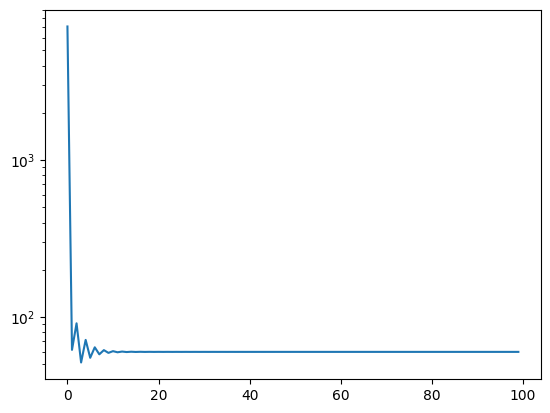

In [24]:
# Executando o algoritmo normal com o melhor L encontrado
g1 = trace_reg_MD(dF, n, d_1, d_2, X, Y, best_L, lambd, tau, a, Gamma0, S0, t_final)
plt.plot(g1[0])
plt.yscale("log")

Best L:  2.0


[]

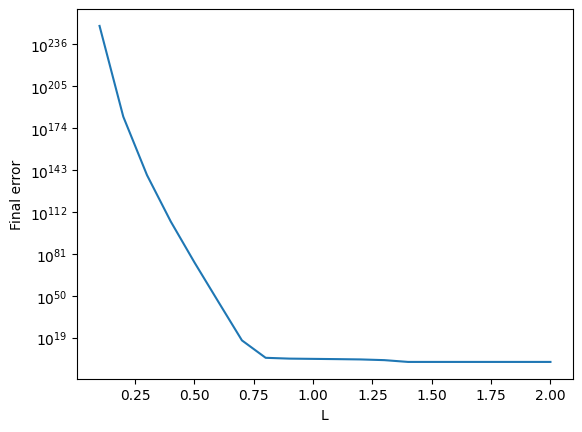

In [25]:
# Otimizando o valor do L para o método acelerado
best_L = 0
best_error = np.infty
Ls = []
Ls_errors = []

for L in np.arange(0.1, 2.01, 0.1):
    g2 = trace_reg_MD_acc(dF, n, d_1, d_2, X, Y, L, lambd, tau, a, Gamma0, S0, t_final)
    Ls.append(L)
    Ls_errors.append(g2[0][-1])
    if g2[0][-1] < best_error:
        best_error = g2[0][-1]
        best_L = L

print("Best L: ", best_L)

plt.plot(Ls, Ls_errors)
plt.yscale("log")
plt.xlabel("L")
plt.ylabel("Final error")
plt.plot()

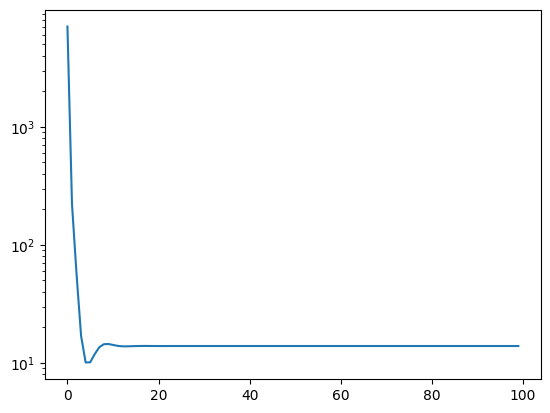

In [26]:
# Executando o algoritmo acelerado para o melhor L encontrado
g2 = trace_reg_MD_acc(dF, n, d_1, d_2, X, Y, L, lambd, tau, a, Gamma0, S0, t_final)
plt.plot(g2[0])
plt.yscale("log")

[]

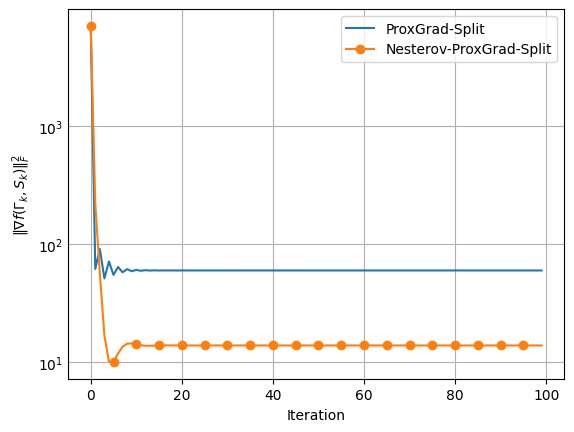

In [27]:
plt.plot(g1[0], label = "ProxGrad-Split")
plt.plot(g2[0], label = "Nesterov-ProxGrad-Split", marker = "o", markevery = 5)
plt.xlabel("Iteration")
plt.ylabel(r"$\|\nabla f(\Gamma_k, S_k)\|_F^2$")
plt.yscale("log")
plt.grid(True)
plt.tick_params(axis = "y", which = "both", length = 0)
plt.legend()
plt.plot()